# Exploratory Data Analysis (TBD)

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from utils.loading import load_masked_images, load_images, load_labels
from utils.visualization import plot_image, plot_images, plot_masked_image
from utils.normalize import normalize
import json
from utils.visualization import plot_predictions

from torchvision import transforms
import torch
import numpy as np
from torch.utils.data import TensorDataset


### Loading the data

In [ ]:
labels = load_labels()
images = load_images(subset=True)
masked_images = load_masked_images(subset=True)

### Exploring the loaded data

In [3]:
example_image = "train_0.tif"

#### Labels

In [ ]:
print("Size of labels:", len(labels))
print("Keys for labels:", list(labels.keys())[:5], end="\n\n")

print(f"Example of labels for {example_image} with {len(labels[example_image])} polygons:")    
for label in labels[example_image]:
    print(label)

#### Images

In [ ]:
print("Keys for images:",images[example_image].keys(), end="\n\n") 
print(f"Profile for {example_image}:")
print(images[example_image]["profile"],end="\n\n")
print(f"Image for {example_image}:")
print(images[example_image]["image"],end="\n\n")

#### Masked images

In [ ]:
print("Keys for masked_images:",masked_images[example_image].keys(), end="\n\n") 
print(f"Profile for masked {example_image}:")
print(masked_images[example_image]["profile"],end="\n\n")
print(f"Masked image for masked {example_image}:")
print(masked_images[example_image]["image"],end="\n\n")

### Checking for nan values

In [ ]:

values = images[example_image]["image"] # The first band
print("Shape of an image:", values.shape)

found_nan = list()
for img in images:
    for i in range(12):
        values = images[img]["image"][i]
        if np.isnan(values).any():
            found_nan.append(img)
            break

print(f"Found {len(found_nan)} images with NaN values: {found_nan}")

But does all bands of one image with NaN values all have the same Nan values?

In [ ]:
different_nan = list()
for img in found_nan:
    nan_mask = np.isnan(images[img]["image"][0])
    for i in range(1, 12):
        nan_mask &= np.isnan(images[img]["image"][i])

    if not nan_mask.any():
        different_nan.append(img)

print(f"Found {len(different_nan)} with different NaN values per band: {different_nan}")

Apparently not. We wanted to look at the NaN values, but this was found to be diffuclt (most of the time) or impossible, as they are most likely too insignificant to be seen.

In [ ]:
count = 0
for img in found_nan:
    if count == 5:
        break
    plot_image(img, num_plots=3)
    plot_image(img, num_plots=3, no_nan=True)
    count += 1

It is difficult to see the difference between including and excluding nan, but we found it to be necessary to remove all nan value before normalizing the image. If we did not remove the nan value, the values of mean and std ended up as nan values. Looking at image train_0.tif, the nan values are visible. 

### Looking at a datapoints profile

In [ ]:
print(images[example_image]["profile"])

### Visualizing a data point

We have already visualized the data point, but let's take a closer look at one specific data point. 

In [ ]:
for i in range(1,9,3):
    # First 6 images including the polygon
    plot_image(example_image, num_plots=1, band=i)
    # Last 6 images excluding the polygon
    plot_image(example_image, num_plots=1, band=i, polygons=False)

To be able to use the images for training we chose to convert them to masked images where each pixel is represented by the class it belongs to (0 if no class, 1-4 for the unique classes). When plotting the image, each class is represented by a color. Let's plot a image.

In [ ]:
plot_masked_image(example_image)

### Can we visualize the locations on a map? (does it exist tools to do this already?)

### Normalizing the data

In [ ]:

image_tensor = torch.tensor([images[img]["image"] for img in images])
image_tensor = torch.nan_to_num(image_tensor, nan=0.0)  # As images inludes NaN values, we replace them with 0.0
print("Shape:", image_tensor.shape, end="\n\n")

normalized_image_tensor = normalize(image_tensor)

print("Before normalization:", image_tensor[0][0][0])
print("After normalization:", normalized_image_tensor[0][0][0], end="\n\n")

plot_image(example_image, num_plots=1)


In [ ]:
subset = True
x_train_dict = load_images(subset)
y_train_dict = load_masked_images(subset)

x_train = [torch.tensor(each['image']) for each in x_train_dict.values()]
y_train = [torch.tensor(each['image']) for each in y_train_dict.values()]

x_train_tensor = torch.stack(x_train, dim=0)  # Shape: [num_samples, 12, 1024, 1024]
y_train_tensor = torch.stack(y_train, dim=0).squeeze(1).long()   # Shape: [num_samples, 1, 1024, 1024]

x_train_tensor = torch.nan_to_num(x_train_tensor, nan=0.0)
x_train_tensor = normalize(x_train_tensor)

train_loader = TensorDataset(x_train_tensor, y_train_tensor)

### How many polygons can one training point have?

In [ ]:
polygon_counts = {}
for img_name in images.keys():
    if img_name in labels:
        polygon_counts[img_name] = len(labels[img_name])
    else:
        polygon_counts[img_name] = 0
    
polygon_counts = dict(sorted(polygon_counts.items(), key=lambda x: int(x[0].split('_')[1].split('.')[0])))

count = 0
for img_name, count in polygon_counts.items():
    if count == 10:
        break
    print(f"{img_name}: {count} polygons")

## Image with the most polygons
max_polygons = max(polygon_counts, key=polygon_counts.get)
print()
print(f"Image with the most polygons: {max_polygons} with {polygon_counts[max_polygons]} polygons")

plot_image(max_polygons, num_plots=1)

### Er det likt distribuert?

## We have run main.py, let's plot the images

Current working directory: /Users/synneandreassen/Documents/MasterMaskinlæring/INF367A/Competition/INF367A-Solafune/notebooks
Found ground truth for train_0.tif
Found prediction for train_0.tif


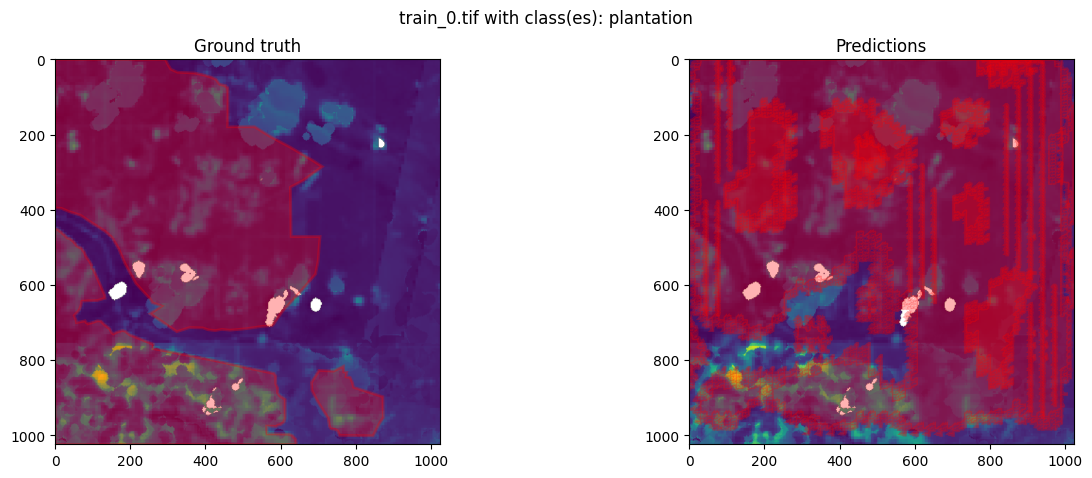

Found ground truth for train_1.tif
Found prediction for train_1.tif


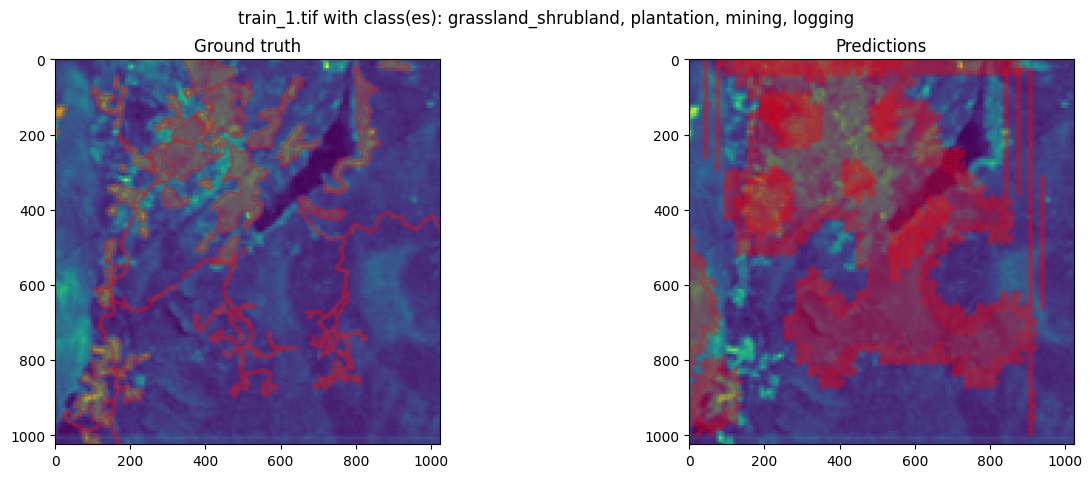

Found ground truth for train_2.tif
Found prediction for train_2.tif


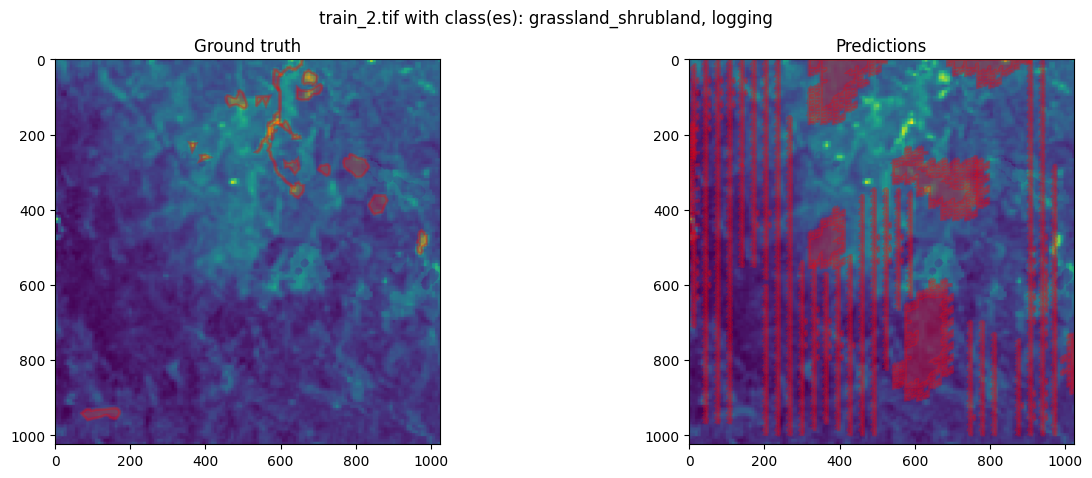

Found ground truth for train_3.tif
Found prediction for train_3.tif


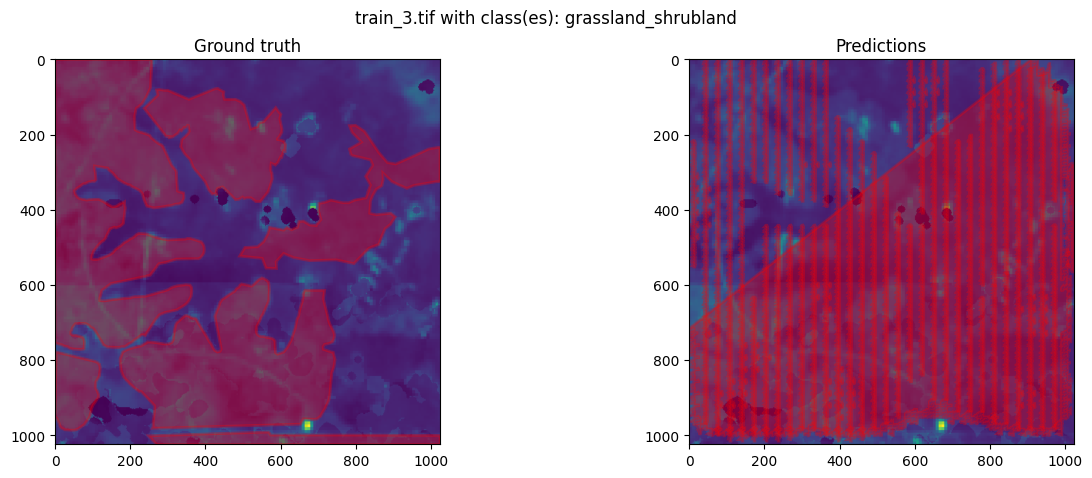

Found ground truth for train_4.tif
Found prediction for train_4.tif


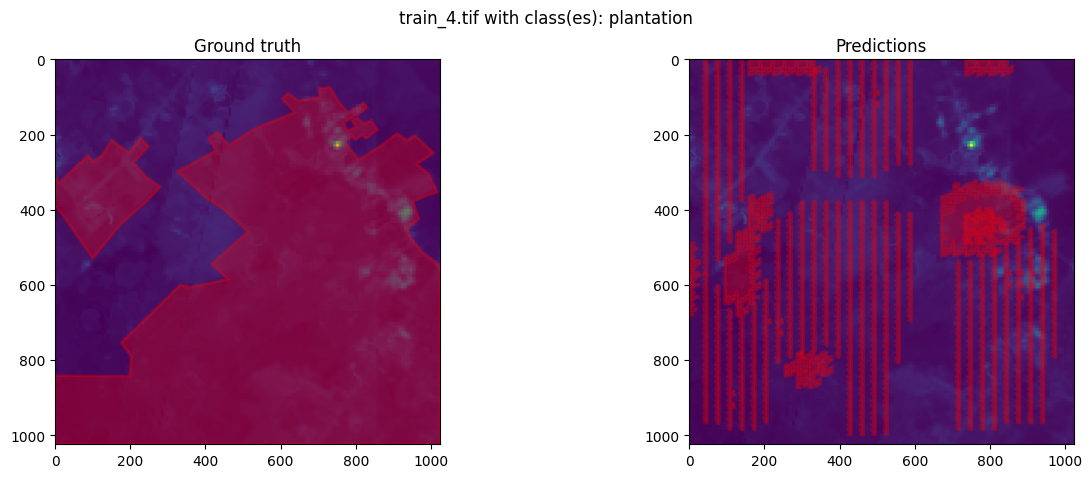

Found ground truth for train_5.tif
Found prediction for train_5.tif


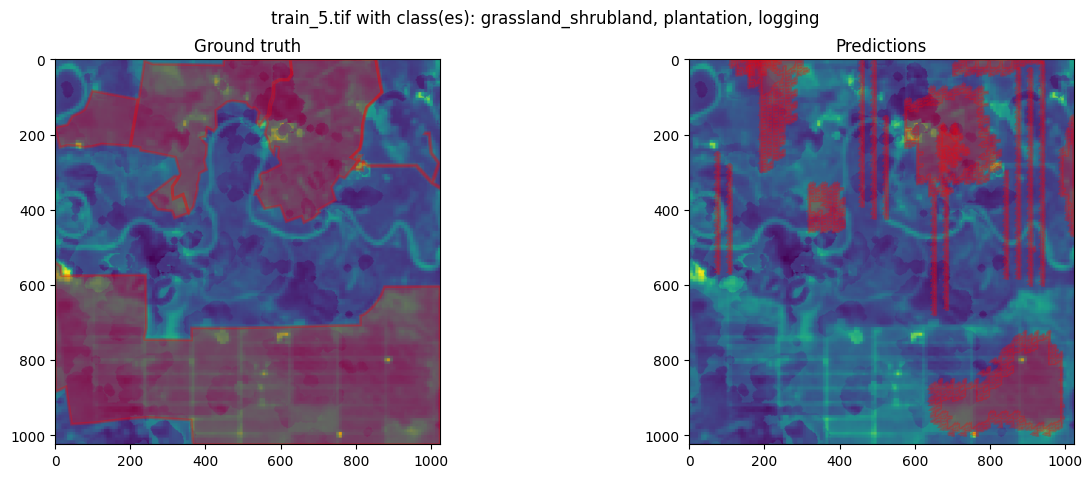

In [ ]:
print(f"Current working directory: {os.getcwd()}")

with open("./../data/predictions/output.json", "r") as f:
    predictions = json.load(f)

for elem in predictions["images"]:
    path = elem["file_name"]
    plot_predictions(path)
